In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# Read train and test file
df = pd.read_csv('train_indessa.csv')
Y = df[['loan_status']].values
# print(df['loan_status'].value_counts())
df_train = df.copy()
df_train = df_train.drop(['loan_status'], axis=1)  
df_test = pd.read_csv('test_indessa.csv')

In [3]:
def data_prepare(df):
    # Class Label : Binary Classification
    import math
    import numpy as np
    
    # Drop column 
    df.drop(['desc', 'zip_code', 'emp_title', 'title', 'batch_enrolled', 'grade','purpose', 'home_ownership', 'addr_state', 'verification_status_joint'], axis=1, inplace=True)

    # Converts categorical variable into dummy variables.
    veri_st = pd.get_dummies(df['verification_status'],drop_first=True)
    pymnt_p = pd.get_dummies(df['pymnt_plan'],drop_first=True)
    initial_l_s = pd.get_dummies(df['initial_list_status'],drop_first=True)
    application_t = pd.get_dummies(df['application_type'],drop_first=True)
    
    df=pd.concat([df, veri_st, pymnt_p, initial_l_s, application_t],axis=1)
    df=df.drop(['verification_status', 'pymnt_plan', 'initial_list_status', 'application_type'], axis=1)

    # Data Preprocessing
    # Replaces months string with '' 
    df['term'].replace(to_replace=' months', value='', regex=True, inplace=True) 
    # Convert it to numeric
    df['term'] = pd.to_numeric(df['term'], errors='coerce')
    
    # Remove string and special character 
    df['emp_length'].replace('n/a', '0', inplace=True)
    df['emp_length'].replace(to_replace='\+ years', value='', regex=True, inplace=True)
    df['emp_length'].replace(to_replace=' years', value='', regex=True, inplace=True)
    df['emp_length'].replace(to_replace='< 1 year', value='0', regex=True, inplace=True)
    df['emp_length'].replace(to_replace=' year', value='', regex=True, inplace=True)

    # Convert it to numeric
    df['emp_length'] = pd.to_numeric(df['emp_length'], errors='coerce')
    
    # Replace character with unique number
    df['sub_grade'].replace(to_replace='A', value='0', regex=True, inplace=True)
    df['sub_grade'].replace(to_replace='B', value='1', regex=True, inplace=True)
    df['sub_grade'].replace(to_replace='C', value='2', regex=True, inplace=True)
    df['sub_grade'].replace(to_replace='D', value='3', regex=True, inplace=True)
    df['sub_grade'].replace(to_replace='E', value='4', regex=True, inplace=True)
    df['sub_grade'].replace(to_replace='F', value='5', regex=True, inplace=True)
    df['sub_grade'].replace(to_replace='G', value='6', regex=True, inplace=True) 

    # Convert it to numeric
    df['sub_grade'] = pd.to_numeric(df['sub_grade'], errors='coerce') 
    
    # Remove string like th week NA
    df['last_week_pay'].replace(to_replace='th week', value='', regex=True, inplace=True)
    df['last_week_pay'].replace(to_replace='NA', value='', regex=True, inplace=True)
    # Convert it to numeric
    df['last_week_pay'] = pd.to_numeric(df['last_week_pay'], errors='coerce')
    
    # Fill missing value using median
    columns = ['term', 'loan_amnt', 'funded_amnt', 'last_week_pay', 'int_rate', 'sub_grade',
               'annual_inc', 'dti', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
               'revol_bal', 'revol_util', 'total_acc', 'total_rec_int', 'mths_since_last_major_derog', 
               'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'emp_length']

    # Filling NaN values with median of each column present in columns.
    for col in columns:
        df[col].fillna(df[col].median(), inplace=True)  

    
    #Filling NaN values with 0 for each column present in columns.
    num_cols = ['acc_now_delinq', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec']
    for col in num_cols:
        df[col].fillna(0, inplace=True)        

    
    # New feature
    # 1. How big the loan a person has taken with respect to his earnings, annual income to fund by bank ratio
    df['income_to_loan'] = np.round_(df['annual_inc']/df['funded_amnt'], decimals = 2)

    # 2. Interest paid so far = interest received till date + Late fee received till date
    df['total_int_paid'] = df['total_rec_int'] + df['total_rec_late_fee']

    # 3. Calculating EMIs (monthly)
    #EMI = [P x R x (1+R)^N] / [(1+R)^N-1]
    principal = df['loan_amnt']
    rate = df['int_rate'] /(100*12)
    time = df['term']

    df['emi_per_month'] = np.round_((principal * rate * (1+rate)**time)/((1+rate)**(time)-1), decimals = 2)

    # 4. Calculating EMIs paid (in terms of percent) np.round_(in_array, decimals = 2)
    df['emi_paid_perc'] = np.round_(((df['last_week_pay'])/(df['term']/12*52+1))*100, decimals = 2)

    # df.describe()
    print("Data set shape:", df.shape)
    return df



In [4]:
# call data preparing function
final_df = data_prepare(df_train)
# X train data
X = final_df[['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'sub_grade', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'last_week_pay', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'Source Verified',
       'Verified', 'y', 'w', 'JOINT', 'income_to_loan',
       'total_int_paid', 'emi_per_month', 'emi_paid_perc']].values


from sklearn.model_selection import train_test_split

# Split the data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(np.array(X), np.array(Y), test_size=0.3,
                                                    random_state=10)


Data set shape: (532428, 39)


In [5]:
#Using Decision Tree classfier
from sklearn.tree import DecisionTreeClassifier

dr = DecisionTreeClassifier(criterion='gini',random_state=10, max_depth = 6)
dr.fit(X_train,Y_train)
Y_pred = dr.predict(X_test)

print(list(zip(Y_test,Y_pred)))
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
confusion_matrix=confusion_matrix(Y_test,Y_pred)
print(confusion_matrix)

print("Classification report: ")
print(classification_report(Y_test,Y_pred))
accuracy_score=accuracy_score(Y_test, Y_pred)
print("Accuracy of the model: ",accuracy_score)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



              precision    recall  f1-score   support

           0       0.96      0.94      0.95    121942
           1       0.83      0.87      0.85     37787

    accuracy                           0.93    159729
   macro avg       0.89      0.91      0.90    159729
weighted avg       0.93      0.93      0.93    159729

Accuracy of the model:  0.9268761464730888


In [6]:
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import roc_auc_score
# AUC ROC score
predictions = [round(value) for value in Y_pred]
accuracy_per_roc_auc = roc_auc_score(Y_test, predictions)
print("ROC-AUC: %.10f%%" % (accuracy_per_roc_auc * 100))

ROC-AUC: 90.8714284605%


In [7]:
# Prepre submission file using output of test dataset
# call data preparing function
finalTest = data_prepare(df_test)
# submission_file_name = 'submission'
# test_member_id = pd.DataFrame(finalTest['member_id'])
# final_pred = pd.DataFrame(dr.predict_proba(np.array(finalTest)))
# dfSub = pd.concat([test_member_id, final_pred.loc[:, 1:2]], axis=1)
# dfSub.rename(columns={1:'loan_status'}, inplace=True)
# dfSub.to_csv((('%s.csv') % (submission_file_name)), index=False)

y_pred_valid = dr.predict(np.array(finalTest))
submission = pd.DataFrame({
        "member_id": finalTest["member_id"],
        "loan_status": y_pred_valid
    })
submission.to_csv('submission.csv', index=False)

Data set shape: (354951, 39)


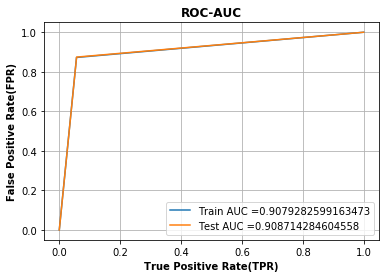

In [8]:
# Plot ROC-AUC graph
y_train_pred = dr.predict(X_train)    
y_test_pred = dr.predict(X_test)


train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)", fontweight='bold')
plt.ylabel("False Positive Rate(FPR)", fontweight='bold')
plt.title("ROC-AUC", fontweight='bold')
plt.grid()
plt.savefig("ROC_AUC.png")
plt.show() 